<a href="https://colab.research.google.com/github/AyushGupta51379/COMP_5331_Project_Fake_News_Detection/blob/master/MVNN_training_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVNN

This piece of work is an implementation of Multi-domain Visual Neural Network (MVNN), which is first proposed in the paper [Exploiting Multi-domain Visual Information for Fake News Detection](https://arxiv.org/abs/1908.04472).

In [1]:
# some basic things to include
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# some preprocessing techniques
from scipy.fftpack import dct

# custom dataset
from torch.utils.data.dataset import Dataset

# this is only required for Google Colab
from google.colab import drive

import time
from datetime import datetime
import matplotlib.pyplot as plt

these modules and dataset require to be downloaded (unless they are executed under a repository)

In [2]:
# Mount your google drive (for later model saving & loading)
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# DCT modules
#print("DCT Module:")
#!gdown --id 1MtVZXrFkLTLQgOhFhbYIUrXT-FMKH2hH
#from dct import DCT, DFT

# download the Weibo dataset
!gdown --id 1gjbSZV5NjjIVOqSP-yTCqXcGPX9PnYn5
!unzip -q '/content/MM17-WeiboRumorSet.zip'
mainfolder = 'MM17-WeiboRumorSet/'
subfolders = {'nonrumor_images': 0, 'rumor_images': 1}
print("Dataset: Weibo is loaded")

# download the Twitter dataset
# !gdown --id 1ydEupxLKCmFYe3nfbpbRyCmHi05Oxt5i
# !unzip -q '/content/Medieval2015_fake_or_real_Images.zip'
# mainfolder = 'Medieval2015_fake_or_real_Images/'
# subfolders = {'non-rumor': 0, 'rumor': 1}
# print("Dataset: Twitter is loaded")

Downloading...
From: https://drive.google.com/uc?id=1gjbSZV5NjjIVOqSP-yTCqXcGPX9PnYn5
To: /content/MM17-WeiboRumorSet.zip
1.35GB [00:25, 52.3MB/s]
Dataset: Weibo is loaded


In [4]:

'''
Usage:
as image preprocessor by calling DCT() as a transform

input: 128*128*3 PIL image
output: 64*256 torch array (histogram)

[128*128] => (crop) => [256 * [8*8]] => (DCT_2d) => [256 * [8 * 8]] => reshape => [256 * 64]  
'''

class DCT(object):
    def __init__(self):
        self.BLOCK_HEIGHT = 8
        self.BLOCK_WIDTH = 8
        self.BLOCK_SIZE = (self.BLOCK_HEIGHT, self.BLOCK_WIDTH)

    def div_block(self, img, block_size):
        img_height = img.height
        img_width = img.width
        block_height = block_size[0]
        block_width = block_size[1]
        assert(img_height % block_height == 0)
        assert(img_width % block_width == 0)

        blocks = []
        for i in range(0,img_height,block_height):
            for j in range(0,img_width,block_width):
                box = (j, i, j+block_width, i+block_height)
                block = np.array(img.crop(box))
                blocks.append(block)
        return np.array(blocks)

    def dct2(self, array_2d):
        return dct(dct(array_2d.T, norm = 'ortho').T, norm = 'ortho')

    def _dct2(self, array_2d):
        return dct(dct(array_2d, norm = 'ortho').T, norm = 'ortho').T

    def __call__(self, img):
        image = img
        blocks = self.div_block(image, self.BLOCK_SIZE)
        b_blocks, g_blocks, r_blocks = blocks[:, :, :, 0], blocks[:, :, :, 1], blocks[:, :, :, 2]
        test_blocks = (b_blocks + g_blocks + r_blocks) / 3 # naive greyscale
        result = np.array([self._dct2(test_block) for test_block in test_blocks])
        # return a torch.tensor
        return torch.from_numpy(result.reshape(256, 64).T).float()

    def __repr__(self):
        return "Simply DCT. What do you expect?"

'''
Usage: Same as DCT()

input: 64*256 torch array (histogram)
output: 64*256 torch array (frequency histogram)
'''
class DFT(object):
    def __init__(self):
        pass

    def __call__(self, freq):
        # convert into complex form containing real and imaginary part
        cmplx = torch.from_numpy(np.zeros((freq.shape[0], freq.shape[1], 2)))
        cmplx[:, :, 0] += freq
        out = torch.fft(cmplx, 1, normalized=True)[:, :, 0]
        return out

    def __repr__(self):
        return "Simply DFT. What do you expect?"


'''
input: PIL loaded image
output: PIL image, in YCbCr color space
'''
class Ycbcr_convert():
    def __init__(self):
        pass

    def __call__(self, img):
        return img.convert('YCbCr')

    def __repr__(self):
        return "Convert a PIL Image from RGB to YCbCr" 

## Image transformers for pixel and freq domain

In [5]:
## Define the image transformers for pixel and freq domain

image_height_pixel, image_width_pixel = 224, 224
image_height_freq, image_width_freq = 128, 128
tform_pixel = transforms.Compose([
    transforms.Resize((image_height_pixel,image_width_pixel), interpolation=Image.BICUBIC),
    transforms.ToTensor()
])
tform_freq = transforms.Compose([
    transforms.Resize((image_height_freq,image_width_freq), interpolation=Image.BICUBIC),
    Ycbcr_convert(),
    DCT(),
    # DFT()
])

def imshow(np_image):
    plt.figure(figsize = (5,5))
    plt.imshow(np_image) # it should be a numpy array
    plt.show()

### Some remarks from AG  
When you use GPU runtime in Colab, apart from the original VM running the notebook, Google will instantiate a new VM with GPU so that parallel computations are forwarded to VM with GPU. \\
Here we load all the data (~1.35GB, while Nvidia Tesla K80 has 12GB RAM) into memory in the beginning. Hence the data transfer between 2 VMs will only be called once, rather than every mini-batch. This is the point which takes most time, while in the training section later it will exhibit huge speedup.

In [6]:
class WeiboRumorDataset(Dataset):
    def __init__(self, tform_pixel, tform_freq, folder, subfolders):        
        self.tform_pixel = tform_pixel
        self.tform_freq = tform_freq
        self.mainfolder = folder
        self.subfolders = subfolders        
        self.data = []
        # load the entire dataset into memory
        for subfolder, label in subfolders.items():
            current = os.path.join(self.mainfolder, subfolder)
            filenames = os.listdir(current)
            for filename in filenames:
                self.data.append([os.path.join(subfolder, filename), label])
            print("[%s]: %d image loaded." % (current, len(filenames)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filepath, label = self.data[idx]
        img = Image.open(os.path.join(self.mainfolder, filepath)).convert('RGB')     
        pixel_input = self.tform_pixel(img)
        freq_input = self.tform_freq(img)
        out = [pixel_input, freq_input, label]
        return out

[MM17-WeiboRumorSet/nonrumor_images]: 5318 image loaded.
[MM17-WeiboRumorSet/rumor_images]: 7954 image loaded.
Total no. of images:  13272


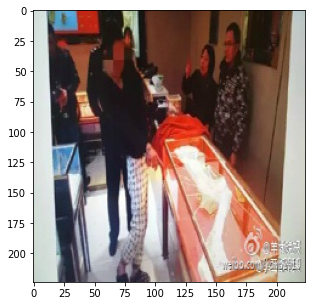

Frequency domain shape: torch.Size([64, 256])
Label: 0


In [7]:
# visualize information of the dataset

dataset = WeiboRumorDataset(tform_pixel, tform_freq, mainfolder, subfolders)
count = dataset.__len__()
print('Total no. of images: ', count)

pixel_input, freq_input, label = dataset.__getitem__(0)
imshow(pixel_input.transpose(0, 1).transpose(1, 2))
print("Frequency domain shape:", freq_input.shape)
print("Label:", label)

## Subnetworks

In [8]:
class CNN(nn.Module):
    def __init__(self, image_height, image_width):
        super(CNN, self).__init__()

        # NOTE:
        # 1. Before each ReLu, a BatchNorm2d layer is added to accelerate convergence (also did by the authors of the paper)

        # Conv Model 1
        self.conv_M1 = nn.Sequential(nn.Conv2d( 3, 32, 3, padding = 1), nn.BatchNorm2d(32), nn.ReLU(),   # (N,  3, 128, 128) --> (N, 32, 128, 128); add padding = 1 for kernel size = 3 to avoid changing output size
                                     nn.Conv2d(32, 32, 1), nn.BatchNorm2d(32), nn.ReLU(),                # (N, 32, 128, 128) --> (N, 32, 128, 128);
                                     nn.MaxPool2d(2))                                                    # (N,  3, 128, 128) --> (N, 32,  64,  64);
                                     
        # Conv Model 2
        self.conv_M2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding = 1), nn.BatchNorm2d(64), nn.ReLU(),  # (N, 32, 64, 64) --> (N, 64, 64, 64)
                                     nn.Conv2d(64, 64, 1), nn.BatchNorm2d(64), nn.ReLU(),               # (N, 64, 64, 64) --> (N, 64, 64, 64)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 64, 64) --> (N, 64, 32, 32)

        # Conv Model 3
        self.conv_M3 = nn.Sequential(nn.Conv2d(64, 64, 3, padding = 1), nn.BatchNorm2d(64), nn.ReLU(),  # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.Conv2d(64, 64, 1), nn.BatchNorm2d(64), nn.ReLU(),               # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 32, 32) --> (N, 64, 16, 16)

        # Conv Model 4
        self.conv_M4 = nn.Sequential(nn.Conv2d( 64, 128, 3, padding = 1), nn.BatchNorm2d(128), nn.ReLU(), # (N,  64, 16, 16) --> (N, 128, 16, 16)
                                     nn.Conv2d(128, 128, 1), nn.BatchNorm2d(128), nn.ReLU(),              # (N, 128, 16, 16) --> (N, 128, 16, 16)
                                     nn.MaxPool2d(2))                                                     # (N, 128, 16, 16) --> (N, 128,  8,  8)
        
        #===== For each branch =====%
        # Note:
        # 1. Flatten convolution layer before FC layer, the input column size = 64 neurons * pooled output size
        # 2. Since image_height and image_width are fed from outside, we need to ensure the type to int after division, otherwise gives bugs.
        # 3. Need to add a dropout layer with a prob of 0.5 after FC layer (see the reference paper)
        # 4. Before each FC layer, a BatchNorm2d layer is added to accelerate convergence

        self.conv_br1 = nn.Sequential(nn.Conv2d(32, 64, 1),
                                      nn.BatchNorm2d(64),
                                      nn.Flatten(1, -1),    # flatten from the 2nd dim (1) to the last dim (-1)
                                      nn.Linear(int(64*image_height*image_width/2/2), 64),
                                      nn.BatchNorm1d(64),
                                      nn.Dropout(0.5))

        self.conv_br2 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.BatchNorm2d(64),
                                      nn.Flatten(1, -1),              
                                      nn.Linear(int(64*image_height*image_width/4/4), 64),
                                      nn.BatchNorm1d(64),  
                                      nn.Dropout(0.5))

        self.conv_br3 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.BatchNorm2d(64),
                                      nn.Flatten(1, -1),    
                                      nn.Linear(int(64*image_height*image_width/8/8), 64),
                                      nn.BatchNorm1d(64),
                                      nn.Dropout(0.5))

        self.conv_br4 = nn.Sequential(nn.Conv2d(128, 64, 1),
                                      nn.BatchNorm2d(64),
                                      nn.Flatten(1, -1),              
                                      nn.Linear(int(64*image_height*image_width/16/16), 64),
                                      nn.BatchNorm1d(64),
                                      nn.Dropout(0.5))

        # FC layer to 2 classes (fake or real) with Softmax to compute prob along the dimension of concatenated features (64*4 = 256)
        self.fc = nn.Sequential(nn.Linear(256, 2),
                                nn.Dropout(0.5))    
                                        #nn.Softmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!
    
    def forward(self, x):
        out1 = self.conv_M1(x)      # Branch 1
        out2 = self.conv_M2(out1)   # Branch 2
        out3 = self.conv_M3(out2)   # Branch 3
        out4 = self.conv_M4(out3)   # Branch 4
        v1 = self.conv_br1(out1)
        v2 = self.conv_br2(out2)
        v3 = self.conv_br3(out3)
        v4 = self.conv_br4(out4)
        v_cat = torch.cat((v1, v2, v3, v4), dim=1)
        # p = self.fc(v_cat)

        # print("\n v1 size:", v1.shape)
        # print("\n v2 size:", v2.shape)
        # print("\n v3 size:", v3.shape)
        # print("\n v4 size:", v4.shape)
        # print("\n v_cat size:", v_cat.shape)
        return v1, v2, v3, v4

class CNN_GRU(CNN):
    def __init__(self, image_height, image_width):
        super(CNN_GRU, self).__init__(image_height, image_width)

        # The 4 GRUs in layer 1
        self.gru1_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)

        # The 4 GRUs in layer 2
        self.gru1_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)

        self.relu = nn.ReLU()

        self.bn = nn.BatchNorm1d(4*2*32)
        self.fc = nn.Sequential(nn.Linear(4*2*32, 2))
                                            # nn.LogSoftmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!
    def forward(self, x):
        v1, v2, v3, v4 = super().forward(x)
        
        v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (4, 64) --> (1, 4, 64)
        v2 = v2.unsqueeze(0)
        v3 = v3.unsqueeze(0)
        v4 = v4.unsqueeze(0)

        # backward GRU (1st layer) which reads from v4 to v1 
        out4_layer1, h4_backward = self.gru4_1(v4)                  # --> (1, N, 32)
        out3_layer1, h3_backward = self.gru3_1(v3, h4_backward)
        out2_layer1, h2_backward = self.gru2_1(v2, h3_backward)
        out1_layer1, h1_backward = self.gru1_1(v1, h2_backward)


        # forward GRU (2nd layer) which reads from v1 to v4 
        out1_layer2, h1_forward = self.gru1_2(h1_backward)          # --> (1, N, 32)
        out2_layer2, h2_forward = self.gru2_2(h2_backward, h1_backward)
        out3_layer2, h3_forward = self.gru3_2(h3_backward, h2_backward)
        out4_layer2, h4_forward = self.gru4_2(h4_backward, h3_backward)

        # concatenating the forward hidden state and the backward hidden state along the feature dimension --> (1, N, 64)
        L1 = torch.squeeze(torch.cat((h1_forward, h1_backward), dim=2)) # --> (N, 64)
        L2 = torch.squeeze(torch.cat((h2_forward, h2_backward), dim=2))
        L3 = torch.squeeze(torch.cat((h3_forward, h3_backward), dim=2))
        L4 = torch.squeeze(torch.cat((h4_forward, h4_backward), dim=2))

        # print("\n L1 size:", L1.shape)
        # print("\n L2 size:", L2.shape)
        # print("\n L3 size:", L3.shape)
        # print("\n L4 size:", L4.shape)

        L_cat = torch.cat((L1, L2, L3, L4), dim=1)    # --> (4, N, 32)
        # print("\n L_cat size:", L_cat.shape)
        
        # p = self.fc(self.bn(L_cat))

        return L1, L2, L3, L4, L_cat

class Frequent_Domain_Subnetwork(nn.Module):
    def __init__(self):
            super(Frequent_Domain_Subnetwork, self).__init__()
            self.backbone = nn.Sequential(nn.Conv1d(64, 32, 3, padding=1),
                                nn.BatchNorm1d(32),
                                nn.ReLU(),
                                nn.MaxPool1d(2),
                                nn.Conv1d(32, 64, 3, padding=1),
                                nn.BatchNorm1d(64),
                                nn.ReLU(),
                                nn.MaxPool1d(2),
                                nn.Conv1d(64, 128, 3, padding=1),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.MaxPool1d(2),
                                nn.Flatten(),
                                nn.Linear(4096, 64),
                                nn.ReLU(),
                                nn.Linear(64, 64))
            
    def forward(self, x):
        out = self.backbone.forward(x)
        return out    

# Models

In [9]:
#=========== Model 1, full MVNN model
class MVNN(nn.Module):
    def __init__(self, image_height_pixel, image_width_pixel):
        super().__init__()
        # subnetworks
        self.pixel_subnet = CNN_GRU(image_height_pixel, image_width_pixel)
        self.freq_subnet = Frequent_Domain_Subnetwork()

        # attention
        self.output_len = 5
        self.dimensions = 64
        self.v = nn.Parameter(torch.rand(self.dimensions, 1))
        self.W = nn.Linear(self.dimensions, self.dimensions)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        # final FC
        self.Wc = nn.Linear(self.dimensions, 2)

    def forward(self, x_pixel, x_freq):
        dimensions = self.dimensions
        output_len = self.output_len

        L1, L2, L3, L4, L_cat = self.pixel_subnet(x_pixel)      
        L0 = self.freq_subnet(x_freq)

        L_all = torch.stack((L0, L1, L2, L3, L4), dim=1) # Bx5x64
        batch_size, output_len, dimensions = L_all.shape
        L_all = self.W(L_all.reshape(batch_size * output_len, dimensions))
        L_all = L_all.reshape((batch_size, output_len, dimensions))
        f = self.tanh(L_all.reshape(batch_size, output_len, dimensions))

        # Bx5x64 bmm 1x64x1 => Bx5x1 => Bx5
        a = self.softmax(torch.matmul(f, self.v).view(batch_size, -1)) 
        # Bx1x5 bmm Bx5x64 => Bx1x64 => Bx64
        u = torch.bmm(a.unsqueeze(1), L_all).view(batch_size, -1)
        out = self.Wc(u) # final output: Bx2
        return out        

#=========== Model 2, w/o freq
class MVNN_wout_freq(nn.Module):
    def __init__(self, image_height_pixel, image_width_pixel):
        super().__init__()

        # subnetworks
        self.pixel_subnet = CNN_GRU(image_height_pixel, image_width_pixel)
        # self.freq_subnet = Frequent_Domain_Subnetwork()     

        # attention
        self.output_len = 5
        self.dimensions = 64
        self.v = nn.Parameter(torch.rand(self.dimensions, 1))
        self.W = nn.Linear(self.dimensions, self.dimensions)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        # final FC
        self.Wc = nn.Linear(self.dimensions, 2)

    def forward(self, x_pixel, x_freq):
        dimensions = self.dimensions
        output_len = self.output_len

        L1, L2, L3, L4, L_cat = self.pixel_subnet(x_pixel)      
        # L0 = self.freq_subnet(x_freq)

        L_all = torch.stack((L1, L2, L3, L4), dim=1) # Bx4x64
        # L_all = torch.stack((L0, L1, L2, L3, L4), dim=1) # Bx5x64

        batch_size, output_len, dimensions = L_all.shape
        L_all = self.W(L_all.reshape(batch_size * output_len, dimensions))
        L_all = L_all.reshape((batch_size, output_len, dimensions))
        f = self.tanh(L_all.reshape(batch_size, output_len, dimensions))

        # Bx4x64 bmm 1x64x1 => Bx5x1 => Bx5
        a = self.softmax(torch.matmul(f, self.v).view(batch_size, -1)) 
        # Bx1x5 bmm Bx5x64 => Bx1x64 => Bx64
        u = torch.bmm(a.unsqueeze(1), L_all).view(batch_size, -1)
        out = self.Wc(u) # final output: Bx2
        return out      

#=========== Model 3, MVNN w/o pixel and attention
class MVNN_wout_pixel(nn.Module):
    def __init__(self, image_height_pixel, image_width_pixel):
        super().__init__()
        # subnetworks
        self.freq_subnet = Frequent_Domain_Subnetwork()

        # final FC
        self.Wc = nn.Linear(64, 2)

    def forward(self, x_pixel, x_freq):

        L0 = self.freq_subnet(x_freq)  # Bx64
        out = self.Wc(L0) # final output: Bx2
        return out


#=========== Model 4, full MVNN w/o attention
class MVNN_wout_att(nn.Module):
    def __init__(self, image_height_pixel, image_width_pixel):
        super().__init__()
        # subnetworks
        self.pixel_subnet = CNN_GRU(image_height_pixel, image_width_pixel)
        self.freq_subnet = Frequent_Domain_Subnetwork()

        # final FC
        self.Wc = nn.Linear(64*5, 2)

    def forward(self, x_pixel, x_freq):

        L1, L2, L3, L4, L_cat = self.pixel_subnet(x_pixel)      
        L0 = self.freq_subnet(x_freq)

        L_all = torch.cat((L0, L1, L2, L3, L4), dim=1) # Bx320
        out = self.Wc(L_all) # final output: Bx2
        return out

#=========== Model 5, MVNN w/o GRU
class MVNN_wout_GRU(nn.Module):
    def __init__(self, image_height_pixel, image_width_pixel):
        super().__init__()
        # subnetworks
        self.pixel_subnet = CNN(image_height_pixel, image_width_pixel) #<-- use CNN instead of CNN_GRU
        self.freq_subnet = Frequent_Domain_Subnetwork()

        # attention
        self.output_len = 5
        self.dimensions = 64
        self.v = nn.Parameter(torch.rand(self.dimensions, 1))
        self.W = nn.Linear(self.dimensions, self.dimensions)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        # final FC
        self.Wc = nn.Linear(self.dimensions, 2)

    def forward(self, x_pixel, x_freq):
        dimensions = self.dimensions
        output_len = self.output_len

        v1, v2, v3, v4 = self.pixel_subnet(x_pixel)      
        L0 = self.freq_subnet(x_freq)

        L_all = torch.stack((L0, v1, v2, v3, v4), dim=1) # Bx5x64
        batch_size, output_len, dimensions = L_all.shape
        L_all = self.W(L_all.reshape(batch_size * output_len, dimensions))
        L_all = L_all.reshape((batch_size, output_len, dimensions))
        f = self.tanh(L_all.reshape(batch_size, output_len, dimensions))

        # Bx5x64 bmm 1x64x1 => Bx5x1 => Bx5
        a = self.softmax(torch.matmul(f, self.v).view(batch_size, -1)) 
        # Bx1x5 bmm Bx5x64 => Bx1x64 => Bx64
        u = torch.bmm(a.unsqueeze(1), L_all).view(batch_size, -1)
        out = self.Wc(u) # final output: Bx2
        return out

#=========== Model 6, MVNN w/o branches (and GRU)
class MVNN_wout_branches(nn.Module):
    def __init__(self, image_height_pixel, image_width_pixel):
        super().__init__()
        # subnetworks
        self.pixel_subnet = CNN(image_height_pixel, image_width_pixel) #<-- use CNN instead of CNN_GRU
        self.freq_subnet = Frequent_Domain_Subnetwork()

        # attention
        self.output_len = 2
        self.dimensions = 64
        self.v = nn.Parameter(torch.rand(self.dimensions, 1))
        self.W = nn.Linear(self.dimensions, self.dimensions)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        # final FC
        self.Wc = nn.Linear(self.dimensions, 2)

    def forward(self, x_pixel, x_freq):
        dimensions = self.dimensions
        output_len = self.output_len

        _, _, _, v4 = self.pixel_subnet(x_pixel)      
        L0 = self.freq_subnet(x_freq)

        L_all = torch.stack((L0, v4), dim=1) # Bx2x64
        batch_size, output_len, dimensions = L_all.shape
        L_all = self.W(L_all.reshape(batch_size * output_len, dimensions))
        L_all = L_all.reshape((batch_size, output_len, dimensions))
        f = self.tanh(L_all.reshape(batch_size, output_len, dimensions))

        # Bx2x64 bmm 1x64x1 => Bx2x1 => Bx2
        a = self.softmax(torch.matmul(f, self.v).view(batch_size, -1)) 
        # Bx1x2 bmm Bx2x64 => Bx1x64 => Bx64
        u = torch.bmm(a.unsqueeze(1), L_all).view(batch_size, -1)
        out = self.Wc(u) # final output: Bx2
        return out  

## Metrics for model evaluation

In [10]:
from sklearn.metrics import accuracy_score # normal accuracy
from sklearn.metrics import balanced_accuracy_score # used in case of imbalanced data sets, average of recall, from 0 to 1
from sklearn.metrics import confusion_matrix # division of performance on the multilabels
from sklearn.metrics import cohen_kappa_score # compares model against random prediction, from -1 to 1
from sklearn.metrics import classification_report # for multilabel classification, gives precision, recall, f score, support, more

def print_metrics(y_true, y_pred, target_names):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:" , balanced_accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Cohen Kappa Score:", cohen_kappa_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

#  function to view one image
def image_show(np_image):
  plt.figure(figsize = (5,5))
  plt.imshow(np_image) # it should be a numpy array
  plt.show()


# Hyper-parameters

In [13]:
# Hyper-parameters
MAX_EPOCH = 300
learning_rate = 0.0001 # adopt a small lr to ensure convergence
batch_size = 32
resumetraining = False

print_every = 20
test_n_savemodel_every_epoch = 2
device = 'cuda'
seed_no = 0
stop_at_loss = 0.1    #before it was 0.1. But it is not very stable.
#================================
modelname = 'MVNN'    # Which model to use?
#================================

## Let's Start Training

In [ ]:
torch.set_deterministic = True
torch.manual_seed(seed_no) # set seed for reproducibility (still some randomness, not stable...)

if modelname == 'MVNN': # hard-coded
  model = MVNN(image_height_pixel, image_width_pixel).to(device)

elif modelname == 'MVNN_wout_freq':
  model = MVNN_wout_freq(image_height_pixel, image_width_pixel).to(device)

elif modelname == 'MVNN_wout_pixel':
  model = MVNN_wout_pixel(image_height_pixel, image_width_pixel).to(device)

elif modelname == 'MVNN_wout_att':
  model = MVNN_wout_att(image_height_pixel, image_width_pixel).to(device)

elif modelname == 'MVNN_wout_GRU':
  model = MVNN_wout_GRU(image_height_pixel, image_width_pixel).to(device)

elif modelname == 'MVNN_wout_branches':
  model = MVNN_wout_branches(image_height_pixel, image_width_pixel).to(device)

else:
  model = []
  print("Error: the selected model is not available!")

# 80% train, 20% test
dataset = WeiboRumorDataset(tform_pixel, tform_freq, mainfolder, subfolders)
trainset, testset = torch.utils.data.random_split(dataset, [int(count*0.8), count-int(count*0.8)])
print('Total no. of train set images: ', len(trainset))
print('Total no. of test set images: ', len(testset))

labels = dataset.subfolders # the dataset saves the subfolder's name as the labels
classes = list(labels.keys()) # convert dict keys into list
print('classes:', classes)

# Load training and test sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True) 
# pixel_input, freq_input, label = next(iter(trainloader)) 
# imshow(pixel_input[1,:,:,:].transpose(0, 1).transpose(1, 2)) # plot figure to check reproduciablility

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=True) 
# pixel_input, freq_input, label = next(iter(testloader))
# imshow(pixel_input[1,:,:,:].transpose(0, 1).transpose(1, 2)) # plot figure to check reproduciablility

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Resume the last trained model?
#================================
resume_epoch = 0
if resumetraining == True:
  # load the model checkpoint
  PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname + "_MAXepoch" + str(MAX_EPOCH)
          + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + '_seed' + str(seed_no) + ".pth")
  print('Loading from ', PATH)

  checkpoint = torch.load(PATH)
  # load model weights state_dict
  model.load_state_dict(checkpoint['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  resume_epoch = checkpoint['epoch']
  # load the criterion
  criterion = checkpoint['loss']
  print('Trained model loss function loaded...')

  # load the acc & loss in the previous epochs
  epoch_acc = checkpoint['epoch_acc']
  epoch_loss = checkpoint['epoch_loss']

  print('\n===== Resuming the Last Training from Epoch %d ... =====' %(resume_epoch))
else:
  epoch_acc = []
  epoch_loss = []
  print('\n===== Start a New Training ... =====')
  

for epoch in range(MAX_EPOCH - resume_epoch):
    total_loss, total_acc = 0, 0
    cnt = 0
    t0 = time.time()

    epoch = epoch + resume_epoch
    for i, data in enumerate(trainloader):

        Xp, Xf = data[0].float().to(device), data[1].float().to(device)
        y = data[2].to(device)        

        optimizer.zero_grad() 
        
        # forward
        out = model(Xp, Xf)        
        #print(out, y_pred)
        loss = criterion(out, y)

        # backward
        loss.backward()
        optimizer.step()

        # stats
        y_pred = torch.argmax(out, dim=1)
        total_acc += (y_pred == y).sum().item() / len(y_pred)
        total_loss += loss.item()

        cnt += 1
        if i % print_every == 0:
            running_loss = total_loss / cnt
            running_acc = total_acc / cnt
            # total_acc, total_loss = 0, 0
            # cnt = 0
            # print(out.T, '\n', y_pred.T, '\n', y.T)
            print('%s: [Epoch %d] [Iter %d/%d] Running Loss: %5f  Running Acc: %5f' 
                  %(modelname, epoch+1, i+1, int(len(trainset)/trainloader.batch_size), running_loss, running_acc))

    # Store the average acc & loss for each epoch for later plotting
    print('Training: Loss = %5f, Acc = %5f' %(running_loss, running_acc))
    epoch_acc.append(running_acc)
    epoch_loss.append(running_loss)

    # Time the training
    t1 = time.time()
    print("Training Time: %10.3f mins" %((t1-t0)/60))

    # Validating
    if (epoch+1) % test_n_savemodel_every_epoch == 0:
      report_every = 10
      test_loss = 0
      cnt = 0
      model.eval()
      y_true = []
      y_pred = []
      with torch.no_grad():
          print('\n===== Start Validating ... =====')
          for data in testloader:
              Xp, Xf = data[0].float().to(device), data[1].float().to(device)
              y = data[2].to(device)

              # prediction
              out = model(Xp, Xf)        
              pred = torch.argmax(out, dim=1)

              loss = criterion(out, y)
              test_loss += loss.item()

              y_true.append(y)
              y_pred.append(pred)

              cnt += 1

              if cnt % report_every == 0:
                  print("[Test] [Epoch %d]  %d / %d batches tested" % (epoch+1, cnt, testloader.__len__()))        

          test_loss = test_loss/cnt
          print("[Test] [Epoch %d] %d / %d batches tested. Test Loss: %5f" % (epoch+1, cnt, testloader.__len__(), test_loss))
      model.train() # Toggle on the training mode to enable back the dropout/batchnorm layers for training
      
      # Print classification report
      y_true = torch.cat(y_true, dim=0)
      y_pred = torch.cat(y_pred, dim=0)
      target_names = ['non-rumor', 'rumor']
      print_metrics(y_true.cpu(), y_pred.cpu(), target_names)
      print('')

      # Save model checkpoint
      PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname + "_MAXepoch" + str(MAX_EPOCH)
              + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + '_seed' + str(seed_no) + ".pth")
      print(PATH)
      torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            'epoch_acc': epoch_acc,
            'epoch_loss': epoch_loss,
            }, PATH)
      print('!!! The trained model is saved !!!') # Make sure you have enough space on google drive

    # Early stopper
    if running_loss < stop_at_loss:
      print('Training is stopped at [Epoch %d] as loss is already very low (%5f)!' %(epoch+1, running_loss))
      break

print('\n===== Finished Training & Validating =====')


# Training graph

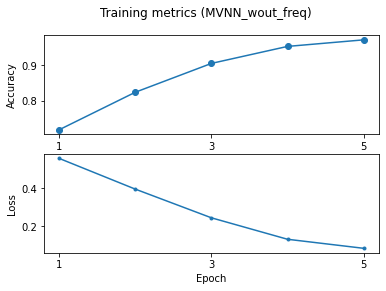

In [ ]:
x = list(range(1, epoch+2))
# print(x)
# print(epoch_acc)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Training metrics (%s)' %(modelname))    
ax1.plot(x, epoch_acc, 'o-')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(list(range(1, epoch+2, 2)))

ax2.plot(x, epoch_loss, '.-')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(list(range(1, epoch+2, 2)))

figname = ("drive/My Drive/Colab Notebooks/trained_models/"+ modelname + "_epoch" + str(epoch+1)
         + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + '_' + 'seed' + str(seed_no) + '_'
         + datetime.today().strftime('%Y-%m-%d') + "v4.pdf")

plt.savefig(figname, bbox_inches='tight')


# Save the trained model

In [ ]:
# Specify a path to your local drive
PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname + "_epoch" + str(epoch+1)
         + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + '_' + 'seed' + str(seed_no) + '_'
         + datetime.today().strftime('%Y-%m-%d') + ".pt")
print(PATH)

# Save the trained model
torch.save(model, PATH)

drive/My Drive/Colab Notebooks/trained_models/MVNN_wout_freq_epoch5_batch32_lr0.0001_seed0_2020-11-04.pt


## Load the trained model from google drive share id

In [ ]:
# Download the trained full MVNN model
# !gdown --id 1-1Io_bGiir9Wq4cgwzkdNrVzseRYX4pa
# PATH = '/content/MVNN_epoch16_batch32_lr0.0001_seed0_2020-10-31.pt'

# Download the trained MVNN without frequency
# !gdown --id 1lAYnZ4OZbivnlkkkzWpc9F6GTLRqpRjO
# PATH = '/content/MVNN_wout_freq_epoch19_batch32_lr0.0001_seed0_2020-10-31.pt'

In [ ]:
model = torch.load(PATH)

In [ ]:
report_every = 10
acc, loss = 0, 0
cnt = 0
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    print('\n===== Start Validating ... =====')
    for data in testloader:
        Xp, Xf = data[0].float().to(device), data[1].float().to(device)
        y = data[2].to(device)

        # prediction
        out = model(Xp, Xf)        
        pred = torch.argmax(out, dim=1)

        y_true.append(y)
        y_pred.append(pred)

        cnt += 1

        if cnt % report_every == 0:
            print("[Test] %d / %d batches tested" % (cnt, testloader.__len__()))        

    print("[Test] %d / %d batches tested" % (cnt, testloader.__len__()))
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    target_names = ['non-rumor', 'rumor']
    print_metrics(y_true.cpu(), y_pred.cpu(), target_names)


===== Start Validating ... =====
[Test] 10 / 82 batches tested
[Test] 20 / 82 batches tested
[Test] 30 / 82 batches tested
[Test] 40 / 82 batches tested
[Test] 50 / 82 batches tested
[Test] 60 / 82 batches tested
[Test] 70 / 82 batches tested
[Test] 80 / 82 batches tested
[Test] 82 / 82 batches tested
Accuracy: 0.8117378048780488
Balanced Accuracy: 0.797647948915823
Confusion Matrix:
 [[ 763  286]
 [ 208 1367]]
Cohen Kappa Score: 0.6027802343746649
Classification Report:
               precision    recall  f1-score   support

   non-rumor       0.79      0.73      0.76      1049
       rumor       0.83      0.87      0.85      1575

    accuracy                           0.81      2624
   macro avg       0.81      0.80      0.80      2624
weighted avg       0.81      0.81      0.81      2624

